# Proyek Tugas Besar Akhir Semester

Pada proyek tugas besar akhir semenster ini, Anda diminta untuk melakukan analisis terhadap sinyal EEG. Dataset yang digunakan adalah dataset publik dari Biometic EEG Dataset EEG [(BED)](https://zenodo.org/record/4309472). Dataset ini terdiri dari beberapa proses perekaman, namun pada proyek ini, hanya data yang direkam pada kondisi __*resting eye closed*__ yang digunakan.

## Sekilas Tentang Data

Untuk membantu proses analisis, berikut sekilas informasi tentang data yang digunakan,

1. Data direkam dengan menggunakan alat Emotiv Epoc+
2. Jumlah channel yang digunakan adalah 14 pada posisi F3, FC5, AF3, F7, T7, P7, O1, O2, P8, T8, F8, AF4, FC6, F4
3. Perhatikan gambar dibawah untuk ilustrasi peletakan channel
4. Perekaman dilakukan dengan menggunakan sampling rate $256 Hz$
5. Durasi perekaman adalah 120 detik. Sehigga, total data poin adalah 30720 data poin

![Emotiv Epoc+ Map](assets/emotiv-epoc-map.jpeg "Emotiv Epoc+ Map")

## Data

Data dapat diunduh melalui tauntan [berikut](https://drive.google.com/drive/folders/1ZaaooG1obcYkCzWewPNOtVzAzpqIqy9X?usp=sharing)

## Tugas

Tugas yang diberikan kepada Anda adalah tugas untuk melakukan tahapan pre-processing pada pengolahan sinyal EEG. Beberapa hal yang harus Anda lakukan adalah,

1. Potong dataset dan gunakan sinyal dari hanya dari kanal AF3, AF4, O1, dan O2 (5 poin)
2. Pastikan sinyal tidak ada line noise pada sinyal EEG ($50/60 Hz$).
    - Anda dapat menggunakan analisis spektogram atau domain frekuensi untuk memastikan keberadaan noise. Tunjukkan hasil analisa Anda, dan sebutkan berapa frekuensi line noise yang terdapat pada data. (10 poin)
    - Desainlah sebuah filter FIR dengan metode window dan gunakan window Hamming untuk memfilter line noise.
        - Berapa orde yang Anda gunakan? Lengkapi dengan proses perhitungan (10 poin)
        - Tampilkan hasil respon impulse dari filter Anda (10 poin)
        - Tampilkan hasil respon frekuensi dari filter Anda (10 poin)
    - Aplikasikan filter yang sudah Anda buat pada kanal AF3, AF4, O1, dan O2 (10 poin)
    - Berikan alasan, apakah filter yang Anda lakukan sudah baik atau belum? (5 poin)
3. Ekstrak gelombang-gelombang otak delta ($0.5 - 4 Hz$), theta ($4 - 8 Hz$), alpha ($8 - 13 Hz$) dengan menggunakan filter IIR metode transformasi bilinier
    - Tentukan model filter dan nilai orde yang Anda gunakan. Jelaskan alasannya (10 poin)
    - Desainlah filter yang Anda pilih untuk setiap gelombang otak (5 poin)
    - Tampilkan respon frekuensi untuk setiap desain filter yang telah Anda buat (5 poin)
    - Aplikasikan desain filter yang Anda telah buat, untuk mendapatkan gelombang-gelombang otak yang diminta. Lakukan pada semua kanal yang diminta dan tampilkan hasilnya (10 poin)
    - Lakukan analisis terhadap hasil ekstraksi gelombang, apakah filter yang Anda desain sudah bekerja sebagaimana mestinya? Hint: Anda dapat menggunakan perubahan bentuk ke frekuensi domain untuk melakukan hal ini (10 poin)

## Penilaian

Bobot penilaian adalah 80% laporan + 20% presentasi

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, firwin, lfilter, filtfilt, freqz
from scipy import pi

data_path = 'data/s1_s1_ec.csv'

df = pd.read_csv(data_path)

display(df.head())
print(f'Dimensi Data: {df.shape}')

,F3,FC5,AF3,F7,T7,P7,O1,O2,P8,T8,F8,AF4,FC6,F4,Timestamp,Date,Time
0,4197.948718,4173.974359,4187.564102,4187.051282,4196.153846,4199.230769,4185.000000,4203.589744,4204.871795,4195.512820,4156.666666,4199.487179,4187.564102,4199.102564,14-04-2018 12:01:43.828,14-04-2018,12:01:43.828
1,4199.102564,4172.564102,4190.128205,4176.282051,4188.461538,4202.820513,4186.282051,4202.692308,4203.974359,4198.333333,4185.769231,4192.820513,4185.000000,4198.461538,14-04-2018 12:01:43.828,14-04-2018,12:01:43.828
2,4190.512820,4171.666667,4184.615384,4185.769231,4186.538461,4202.692308,4186.923077,4198.846154,4199.871795,4187.051282,4200.897436,4180.000000,4185.641026,4189.871795,14-04-2018 12:01:43.831,14-04-2018,12:01:43.831
3,4189.615384,4168.717949,4186.666667,4182.820513,4187.692308,4195.769231,4185.897436,4198.589743,4201.410256,4183.846154,4166.923077,4198.333333,4191.025641,4198.846154,14-04-2018 12:01:43.832,14-04-2018,12:01:43.832
4,4198.846154,4176.666667,4193.205128,4184.230769,4184.743590,4202.051282,4189.743590,4203.846154,4203.461538,4198.846154,4196.666667,4194.743590,4193.846154,4196.923077,14-04-2018 12:01:43.832,14-04-2018,12:01:43.832


Dimensi Data: (30720, 17)


# Kunci

## Soal 1 - Ambil Channel AF3, AF4, O1, dan O2

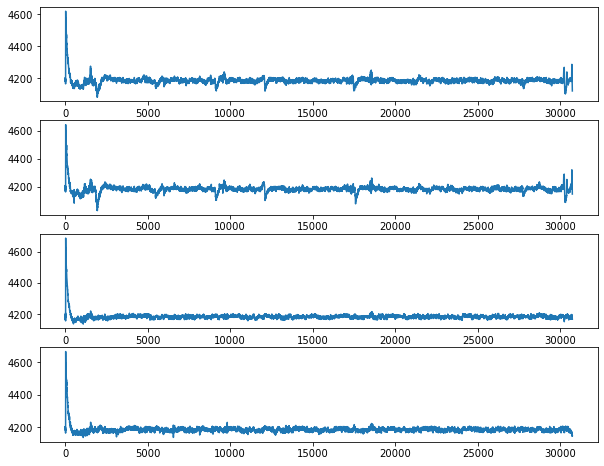

In [2]:
import matplotlib.pyplot as plt

# Ambil channel yang spesifik
af3, af4, o1, o2 = df["AF3"], df["AF4"], df["O1"], df["O2"]

# Plot sinyal untuk cek

fig, axs = plt.subplots(4, figsize=(10,8))
axs[0].plot(af3)
axs[1].plot(af4)
axs[2].plot(o1)
axs[3].plot(o2)

## Soal 2a - Cek Noise 50/60 Hz

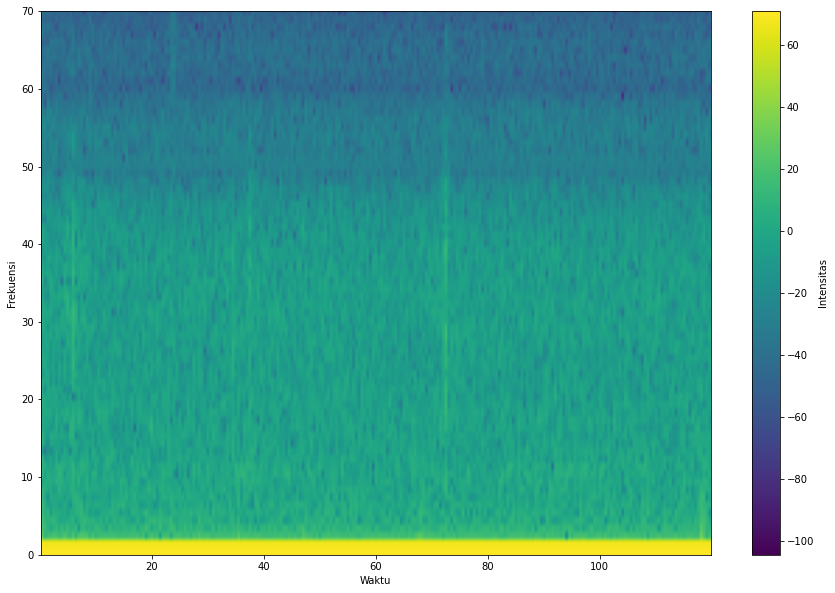

In [3]:
# Spektrogram dengan Matplotlib
plt.figure(figsize=(15,10))
powerSpectrum, freqFound, time, imgAxs = plt.specgram(af3.values, Fs=256)
plt.xlabel('Waktu')
plt.ylabel('Frekuensi')
plt.ylim(0, 70) # limit frekuensi dari 0 - 70 saja
plt.colorbar(imgAxs).set_label('Intensitas')

Jika diperhatikan pada spectogram, maka akan nampak semacam garis pada frekuensi $50Hz$ dan $60Hz$ yang menunjukkan intensitas tertentu dari frekuensi tersebut. Dikonfimasi melalui [laman resmi emotiv epoc+](https://www.emotiv.com/product/emotiv-epoc-14-channel-mobile-eeg/#tab-description), mereka telah menggunakan digital filter untuk memfilter frekeunsi tersebut.

Kita dapat menggunakan ***notch filter*** untuk memfilter frekeunsi $50Hz$ atau $60Hz$. Notch filter adalah filter berbasis bandstop filter (BSF) yang mempunyai rentang yang sempit. Di Indonesia lebih sering menggunakan $50Hz$. Akan tetapi, karena pembasan dikelas tidak sampai dengan materi notch filter, maka filter dilakukan pada tentang $45-55Hz$ untuk menangkap frekuensi $50Hz$. Artinya, akan ada transisi sebesar $5Hz$

Mahasiswa dibebaskan untuk besaran transisi yang digunakan, atau dapat menggunakan notch filter.

## Soal 2b-1 - Orde FIR Filter

Kita akan menggunakan BSF Hamming untuk kasus ini dengan $f_1 = 45Hz$ dan $f_2 = 55Hz$. Transition band adalah $5Hz$.
Catatan: Mahasiswa bebas menentukan rentang transition band, asalah alasan tepat dan dapat dibuktikan dengan analisis hasil filter

Sehingga,
$$
\Delta{f} = \frac{transtion band}{f_s} = \frac{5}{256} = 0.0195
$$

Transition band hamming adalah,
$$
\frac{3.3}{N+1}
$$

Sehingga,
$$ 0.0195 = \frac{3.3}{N+1} $$

$$ N+1 = \frac{3.3}{0.0195} $$

$$ N+1 = 169.230 \approx 169 $$

$$ N = 168 $$

Berdasarkan transition band, maka orde yang digunakan adalah 168. Sehingga, panjang dari window Hanning yang digunakan adalah $orde+1 = 169$

## Soal 2b-2 - Response Impulse Dari Desain Filter

[-0.0005  0.0001  0.0006  0.0003 -0.0005 -0.0006  0.0001  0.0008  0.0005
 -0.0005 -0.0009 -0.      0.001   0.0008 -0.0006 -0.0012 -0.0003  0.0011
  0.0011 -0.0005 -0.0014 -0.0005  0.0011  0.0012 -0.0003 -0.0013 -0.0006
  0.0008  0.0009 -0.     -0.0007 -0.0003  0.0001 -0.0001 -0.      0.0007
  0.0008 -0.0007 -0.002  -0.0006  0.0026  0.003  -0.0013 -0.0051 -0.0022
  0.0049  0.0065 -0.0012 -0.0089 -0.0052  0.007   0.0113 -0.     -0.0132
 -0.0096  0.0083  0.017   0.0027 -0.0173 -0.0153  0.0084  0.0229  0.007
 -0.0202 -0.0219  0.0066  0.0283  0.0126 -0.0215 -0.0284  0.0032  0.0322
  0.0189 -0.0207 -0.034  -0.0018  0.0339  0.025  -0.0178 -0.0377 -0.0075
  0.0332  0.0301 -0.0131  0.9609 -0.0131  0.0301  0.0332 -0.0075 -0.0377
 -0.0178  0.025   0.0339 -0.0018 -0.034  -0.0207  0.0189  0.0322  0.0032
 -0.0284 -0.0215  0.0126  0.0283  0.0066 -0.0219 -0.0202  0.007   0.0229
  0.0084 -0.0153 -0.0173  0.0027  0.017   0.0083 -0.0096 -0.0132 -0.
  0.0113  0.007  -0.0052 -0.0089 -0.0012  0.0065  0.0049

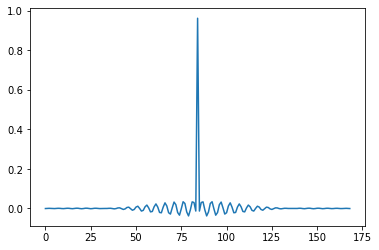

In [13]:
# Definisikan spek filter
n = 169 # panjang filter -> orde + 1
fs = 256 # tidak 1/2 fs karena digunakan untuk pendefinisian firwin (cara ini juga dpt dilakukan)
bsf_range = np.array([47.5, 52.5]) # rentang BSF ternormalisasi (tengah antara 45 dan 50, tengah antra 50 dan 55)

# Kalkulasi h(n)
b = firwin(n, bsf_range, window='hamming', fs=fs, pass_zero='bandstop')
np.set_printoptions(precision=4) # bulatkan 4 angkat koma
np.set_printoptions(suppress=True) # hilangkan nilai e
print(b)

# Plot h(n)
plt.plot(b)

## Soal 2b-3 - Response Frekunesi dari Desain Filter

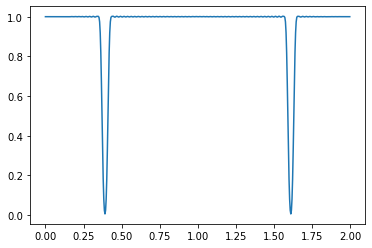

In [14]:
# Kalkulasi FFT dari h(n)
w, h = freqz(b, 1, whole=True)
plt.figure(2)
plt.plot(w/pi, abs(h))

## Soal 2c - Aplikasi Filter ke AF3, AF4, O1, dan O2

Text(0.5, 1.0, 'AF3 Filter 50Hz')

<Figure size 432x288 with 0 Axes>

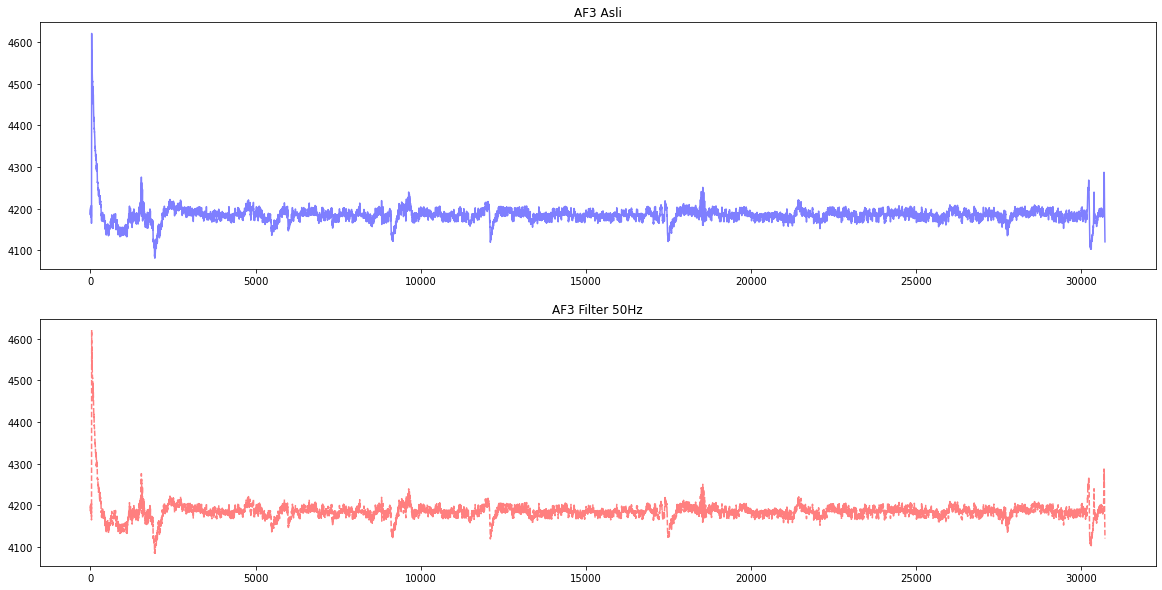

In [15]:
# Contoh salah satu. Apply filter ke AF3
# dengan filtfilt

af3_ff = filtfilt(b, 1, af3.values)

plt.figure()
fig, axs = plt.subplots(2, figsize=(20,10))
axs[0].plot(af3.values, 'b', alpha=0.5)
axs[0].set_title('AF3 Asli')
axs[1].plot(af3_ff, 'r--', alpha=0.5)
axs[1].set_title('AF3 Filter 50Hz')

## Soal 2d - Apakah filter sudah bekerja dengan baik?

Dari tampilan time domain, sekilas tidak ada perbedaan yang berarti. Namun, kita perlu cek lagi dengan menggunakan domain yang lain, misal dibantu dengan spektogram untuk mengetahui intensitas frekuensi setiap waktu.

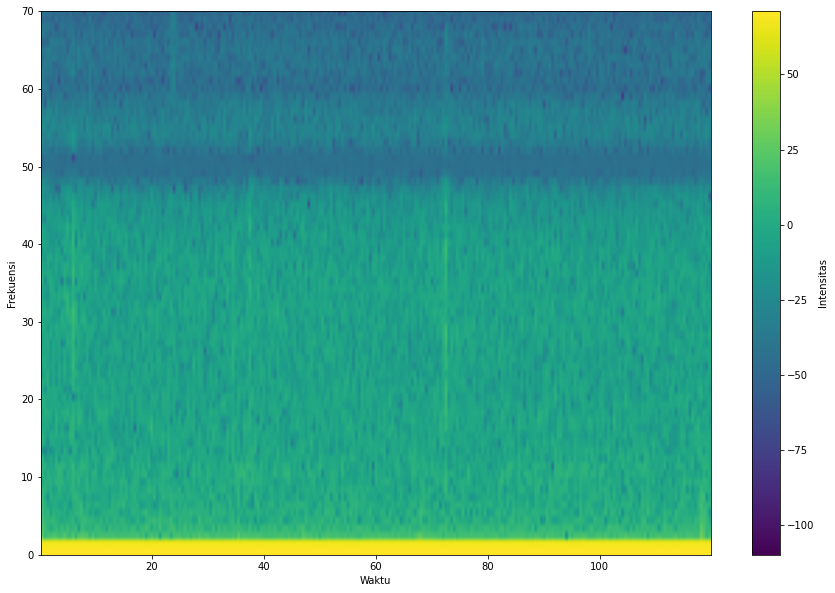

In [16]:
# Cek dengan spektogram

plt.figure(figsize=(15,10))
powerSpectrum, freqFound, time, imgAxs = plt.specgram(af3_ff, Fs=256)
plt.xlabel('Waktu')
plt.ylabel('Frekuensi')
plt.ylim(0, 70) # limit frekuensi dari 0 - 70 saja
plt.colorbar(imgAxs).set_label('Intensitas')

Terlihat dari spektogram bahwa perbedaan intensitas pada rentang frekuensi $45-55Hz$ dibandingkan dengan sinyal AF3 asli (raw). Warna lebih cenderung ke biru, sehingga intensitas berkisar $-(40) $ sampai $-(60) dB$

Sehingga dapat disimpulkan bahwa filter FIR Window dapat bekerja dengan cukup baik untuk menghilangkan noise $50Hz$

## Soal 3a - Desain Filter dan Orde

1. Jenis filter lazim digunakan untuk pengolahan sinyal EEG adalah Butterworth karena tidak memiliki ripple baik pada passband maupun stopband
2. Orde yang lazim digunakan adalah orde 3 atau 4 karena tidak terlalu landai dan tidak terlalu curam (memerikan kesempatan adanya transition)

Mahasiswa bebeas milih jenis filter dengan alasan yang kuat (berdasarkan literatur)

## Soal 3b - Desain Filter untuk Delta, Theta, Alpha

### Gelombang Delta (0.5-4Hz)

In [17]:
# Orde 3
fs = 256
nyq = 0.5 * fs # setengah dari fs karena digital filter

low_d = 0.5 / nyq # low 0.5 Hz
high_d = 4 / nyq # high 4 Hz

b_d, a_d = butter(3, [low_d, high_d], btype='bandpass')

### Gelombang Theta (4-8Hz)

In [18]:
low_t = 4 / nyq # low 4 Hz
high_t = 8 / nyq # high 8 Hz

b_t, a_t = butter(3, [low_t, high_t], btype='bandpass')

### Gelombang Alpha (8-13Hz)

In [19]:
low_a = 8 / nyq # low 8 Hz
high_a = 13 / nyq # high 13 Hz

b_a, a_a = butter(3, [low_a, high_a], btype='bandpass')

## Soal 3b - Hasil Response Frekuensi setiap Gelombang

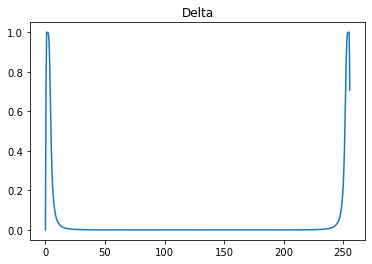

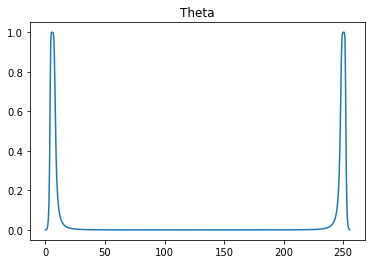

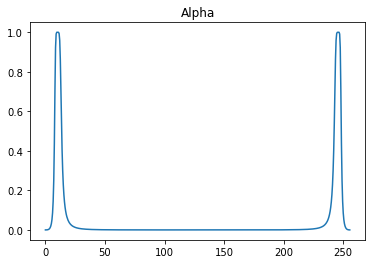

In [20]:
# delta
w_d, h_d = freqz(b_d, a_d, fs=fs, whole=True)
plt.figure(1)
plt.title('Delta')
plt.plot(w_d, abs(h_d))

# theta
w_t, h_t = freqz(b_t, a_t, fs=fs, whole=True)
plt.figure(2)
plt.title('Theta')
plt.plot(w_t, abs(h_t))

# alpha
w_a, h_a = freqz(b_a, a_a, fs=fs, whole=True)
plt.figure(3)
plt.title('Alpha')
plt.plot(w_a, abs(h_a))

**Perhatikan setiap start dari setiap gelombang, akan nampak perbedaannya**

## Soal 3c - Aplikasikan filter

Pada pembahasan ini hanya akan diberikan contoh untuk pengaplikasian filter pada AF3. Untuk channel yang lain, langkah-langkahnya sama.

### Delta

<Figure size 432x288 with 0 Axes>

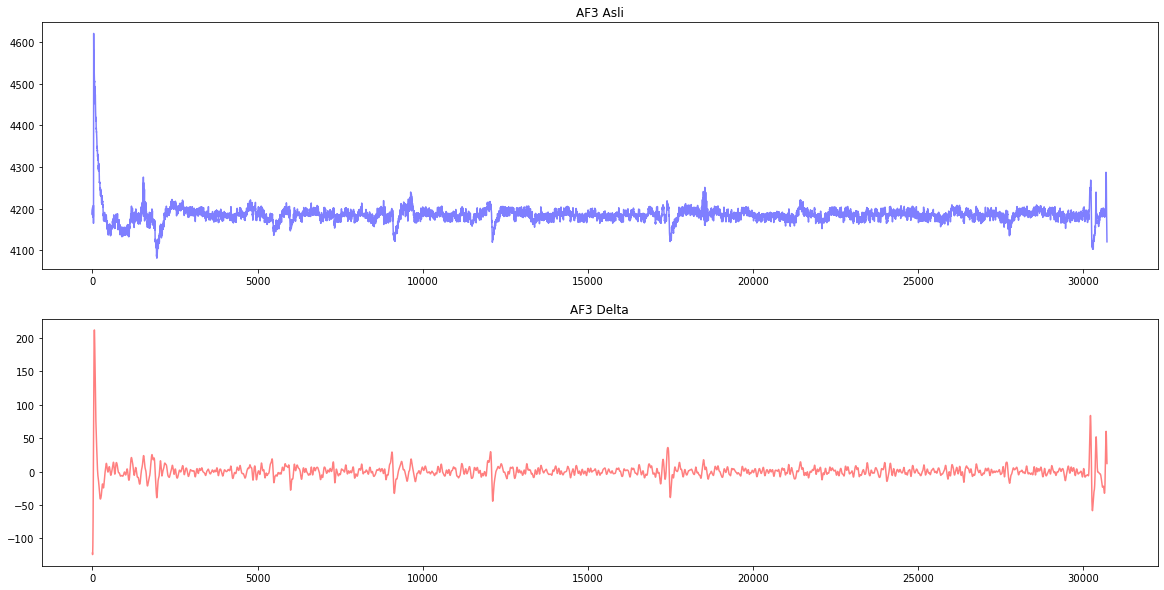

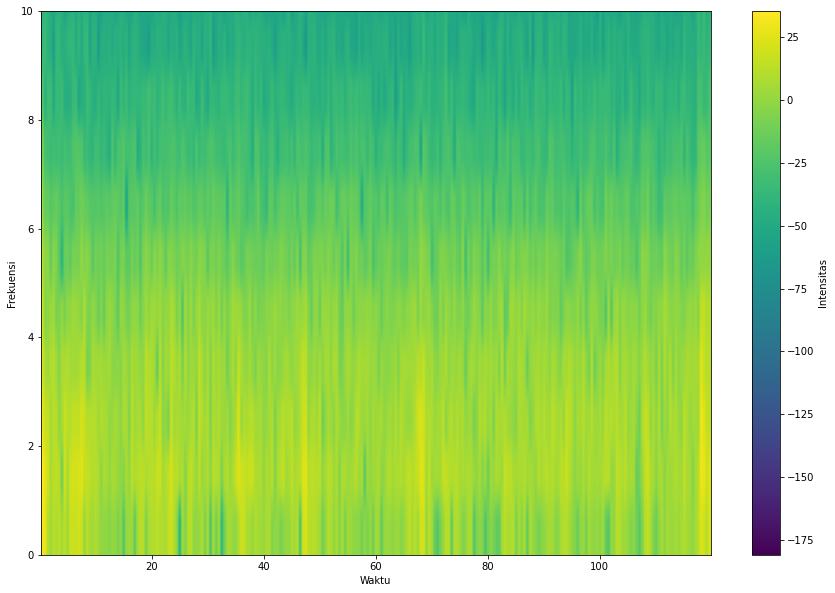

In [21]:
# Proses filter menggunakan fungsi 'filtfilt' dari 'scipy'
# delta
af3_delta = filtfilt(b_d, a_d, af3_ff) # masukkan sinyal AF3 hasil dari line noise filter

# Cek hasil
plt.figure()
fig, axs = plt.subplots(2, figsize=(20,10))
axs[0].plot(af3.values, 'b', alpha=0.5)
axs[0].set_title('AF3 Asli')
axs[1].plot(af3_delta, 'r', alpha=0.5)
axs[1].set_title('AF3 Delta')

# Cek dengan spektogram
plt.figure(figsize=(15,10))
powerSpectrum, freqFound, time, imgAxs = plt.specgram(af3_delta, Fs=256)
plt.xlabel('Waktu')
plt.ylabel('Frekuensi')
plt.ylim(0, 10) # limit frekuensi dari 0 - 10 saja
plt.colorbar(imgAxs).set_label('Intensitas')

### Theta

<Figure size 432x288 with 0 Axes>

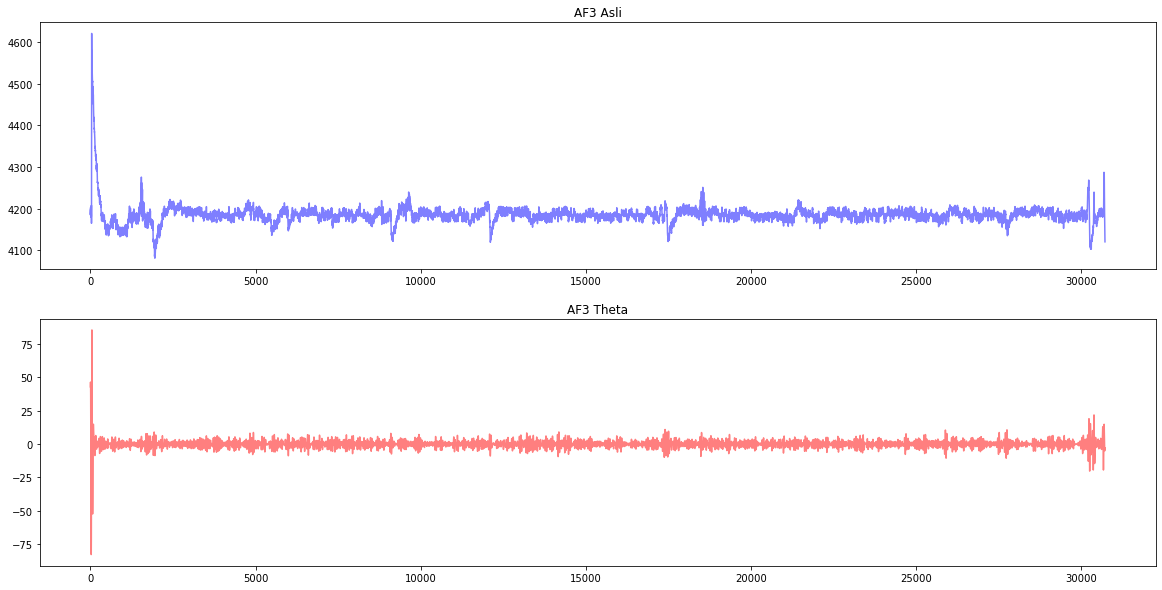

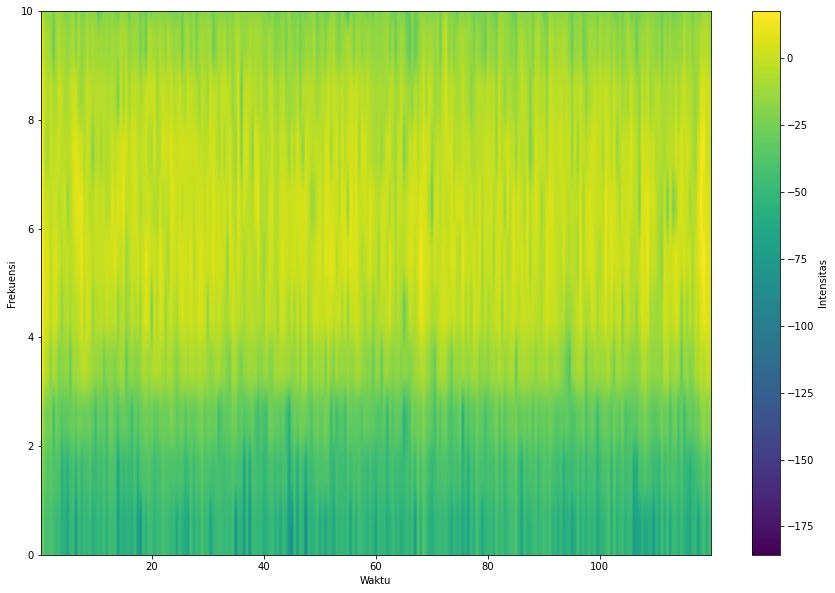

In [22]:
# Proses filter menggunakan fungsi 'filtfilt' dari 'scipy'
# delta
af3_theta = filtfilt(b_t, a_t, af3_ff) # masukkan sinyal AF3 hasil dari line noise filter

# Cek hasil
plt.figure()
fig, axs = plt.subplots(2, figsize=(20,10))
axs[0].plot(af3.values, 'b', alpha=0.5)
axs[0].set_title('AF3 Asli')
axs[1].plot(af3_theta, 'r', alpha=0.5)
axs[1].set_title('AF3 Theta')

# Cek dengan spektogram
plt.figure(figsize=(15,10))
powerSpectrum, freqFound, time, imgAxs = plt.specgram(af3_theta, Fs=256)
plt.xlabel('Waktu')
plt.ylabel('Frekuensi')
plt.ylim(0, 10) # limit frekuensi dari 0 - 10 saja
plt.colorbar(imgAxs).set_label('Intensitas')

### Alpha

<Figure size 432x288 with 0 Axes>

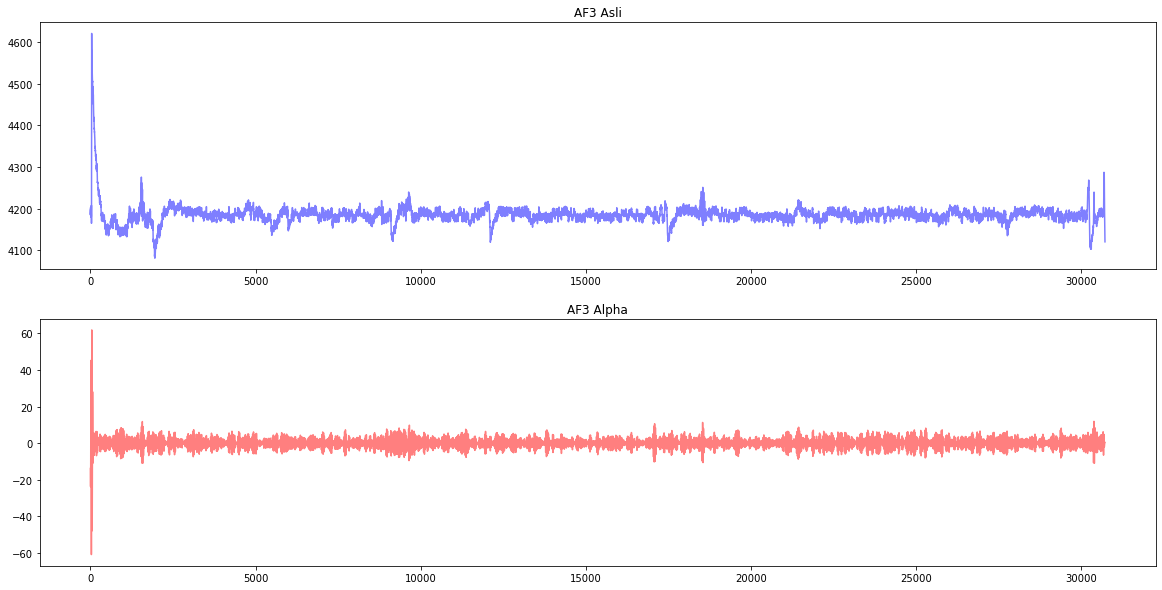

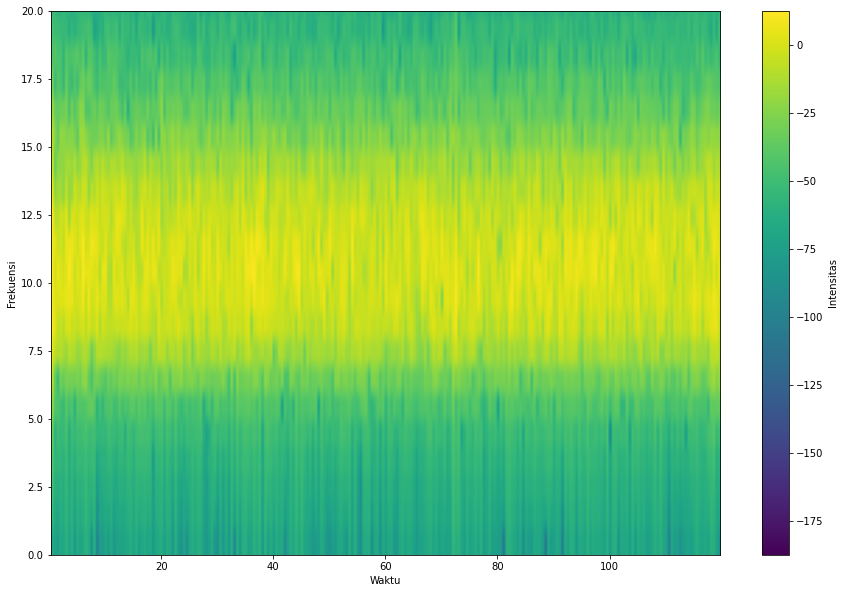

In [23]:
# Proses filter menggunakan fungsi 'filtfilt' dari 'scipy'
# delta
af3_alpha = filtfilt(b_a, a_a, af3_ff) # masukkan sinyal AF3 hasil dari line noise filter

# Cek hasil
plt.figure()
fig, axs = plt.subplots(2, figsize=(20,10))
axs[0].plot(af3.values, 'b', alpha=0.5)
axs[0].set_title('AF3 Asli')
axs[1].plot(af3_alpha, 'r', alpha=0.5)
axs[1].set_title('AF3 Alpha')

# Cek dengan spektogram
plt.figure(figsize=(15,10))
powerSpectrum, freqFound, time, imgAxs = plt.specgram(af3_alpha, Fs=256)
plt.xlabel('Waktu')
plt.ylabel('Frekuensi')
plt.ylim(0, 20) # limit frekuensi dari 0 - 20 saja
plt.colorbar(imgAxs).set_label('Intensitas')

## Soal 3e - Apakah filter sudah bekerja dengan cukup baik?

Meskipun tidak sempurna, filter gelombang dengan IIR Butterworth berkerja dengan cukup baik dilihat dari intensitasnya